In [68]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import statsmodels
from distutils.version import LooseVersion as Version
from string import ascii_letters
import seaborn as sns

import sklearn
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from textblob import TextBlob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

import datetime
from random import sample

from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Price Prediction

## Business Issue Understanding

Let’s say that an owner opens a new housing business in Seattle city. Then, the owner may want to know what price he or she can set for rent. We want to build a model that can predict a housing price based on its properties such as space, the number of beds, rooms, etc

In [275]:
# read data set 
df = pd.read_csv('data/seattle/listings.csv')

In [276]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [306]:
df=df.dropna(axis=0)

In [292]:
# remove columns with missing values more than 40%
columns = df.columns
columns = columns[(len(df) - df.count()) / len(df) < 0.4]
df = df[columns]

In [293]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
 

## Prepare Data

In [294]:
'''NLP will not be used in the creation of an initial model 
(although they could be used to augment the model later, 
e.g. through sentiment analysis). Therefore, free text columns will be
dropped for now, as will other columns which are not useful for predicting price 
(e.g. url, host name and other host-related features that are unrelated to the property).

'''
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 
                'name', 'summary', 'space', 'description', 
                'neighborhood_overview', 'transit', 'thumbnail_url', 
                'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 
                'host_url', 'host_name', 'host_location', 'host_about', 
                'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                'host_verifications', 'calendar_last_scraped']
df = df.drop(cols_to_drop, axis=1)

In [295]:
# city most of values in city column are seattle
# all of them are usa
# all values in those two columns are the same
print(sum((df.host_listings_count == df.host_total_listings_count) / len(df)))

df = df.drop(columns = ['host_acceptance_rate', 'guests_included', 'requires_license', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'jurisdiction_names'])
df = df.drop(columns = ['country', 'city', 'calendar_updated', 'smart_location', 'is_location_exact', 'experiences_offered', 'host_has_profile_pic', 'country_code', 
         'has_availability', 'require_guest_profile_picture', 'host_total_listings_count', 
         'longitude', 'latitude', 'state', 'street', 'market', 'host_since', 'cleaning_fee'])

0.9994761655317531


In [296]:
df['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [298]:
# amenities features are categorical multiple values 
# so we will represent each category as binary value
df['amenities'] = df['amenities'].str.replace('\"', '')
df['amenities'] = df['amenities'].str.replace('{', '')
df['amenities'] = df['amenities'].str.replace('}', '')
df['amenities'] = df['amenities'].str.replace(' ', '_')

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df['amenities'].str.split(',')),
                           columns=mlb.classes_).add_prefix('A_'))

df = df.drop(columns = ['amenities', 'A_'])

In [299]:
# select categorical data
cat_vars = df.select_dtypes(include=['object']).columns

In [300]:
cat_vars

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_identity_verified', 'zipcode', 'property_type', 'room_type',
       'bed_type', 'price', 'extra_people', 'first_review', 'last_review',
       'instant_bookable', 'cancellation_policy',
       'require_guest_phone_verification'],
      dtype='object')

In [301]:
df.columns

Index(['id', 'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified', 'zipcode',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
       'A_24-Hour_Check-in', 'A_Air_Conditioning', 'A_Breakfast',
       'A_Buzzer/Wireless_Intercom', 'A_Cable_TV',
       'A_Carbon_Monoxide_Detector', 'A_Cat(s)', 'A_Dog(s)', 'A_Doorm

In [302]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float')
df = df.drop(columns=['first_review', 'last_review'])
df['extra_people'] = df['extra_people'].str.replace('$', '').astype(float)

In [303]:
# drop target values from dataframe and pharse it to integer value
df['price'] = df['price'].str[1:-3]
df['price'] = df['price'].str.replace(",", "").astype('int64')
y = df['price']

In [304]:
# create dummy variables for categorical features
num_vars = df.select_dtypes(include=['float', 'int']).columns
    
for col in num_vars:
    df[col].fillna(df[col].mean(), inplace=True)

In [305]:
df.head()

,id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,zipcode,property_type,room_type,accommodates,...,A_Safety_Card,A_Shampoo,A_Smoke_Detector,A_Smoking_Allowed,A_Suitable_for_Events,A_TV,A_Washer,A_Washer_/_Dryer,A_Wheelchair_Accessible,A_Wireless_Internet
0,241032,within a few hours,96.0,f,3.0,t,98119,Apartment,Entire home/apt,4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,953595,within an hour,98.0,t,6.0,t,98119,Apartment,Entire home/apt,4,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,3308979,within a few hours,67.0,f,2.0,t,98119,House,Entire home/apt,11,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,278830,within an hour,100.0,f,2.0,t,98119,House,Entire home/apt,6,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1909058,within an hour,100.0,t,1.0,t,98119,House,Private room,2,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [275]:
df['property_type'].value_counts()

House              1298
Apartment          1274
Townhouse            74
Condominium          65
Loft                 31
Bed & Breakfast      25
Cabin                20
Other                17
Bungalow              9
Camper/RV             9
Dorm                  2
Tent                  1
Chalet                1
Treehouse             1
Boat                  1
Yurt                  1
Name: property_type, dtype: int64

In [276]:
# convert categorical data into dummy binary values
cat_vars = df.select_dtypes(include=['object']).columns
for var in cat_vars:
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_')], axis=1)

In [277]:
def dist_plot(dist, fsize=None):
    """
    Description: This function takes a sequence of real values and plots the histgram distribution

    Arguments:
        dist: input sequence data

    Returns: 
        None
    """
    dist.hist(figsize=fsize);

In [278]:
X = df.drop(columns=['id', 'price'])
X.columns.values

array(['host_response_rate', 'host_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'A_24-Hour_Check-in', 'A_Air_Conditioning',
       'A_Breakfast', 'A_Buzzer/Wireless_Intercom', 'A_Cable_TV',
       'A_Carbon_Monoxide_Detector', 'A_Cat(s)', 'A_Dog(s)', 'A_Doorman',
       'A_Dryer', 'A_Elevator_in_Building', 'A_Essentials',
       'A_Family/Kid_Friendly', 'A_Fire_Extinguisher', 'A_First_Aid_Kit',
       'A_Free_Parking_on_Premises', 'A_Gym', 'A_Hair_Dryer', 'A_Hangers',
       'A_Heating', 'A_Hot_Tub', 'A_Indoor_Fireplace', 'A_Int

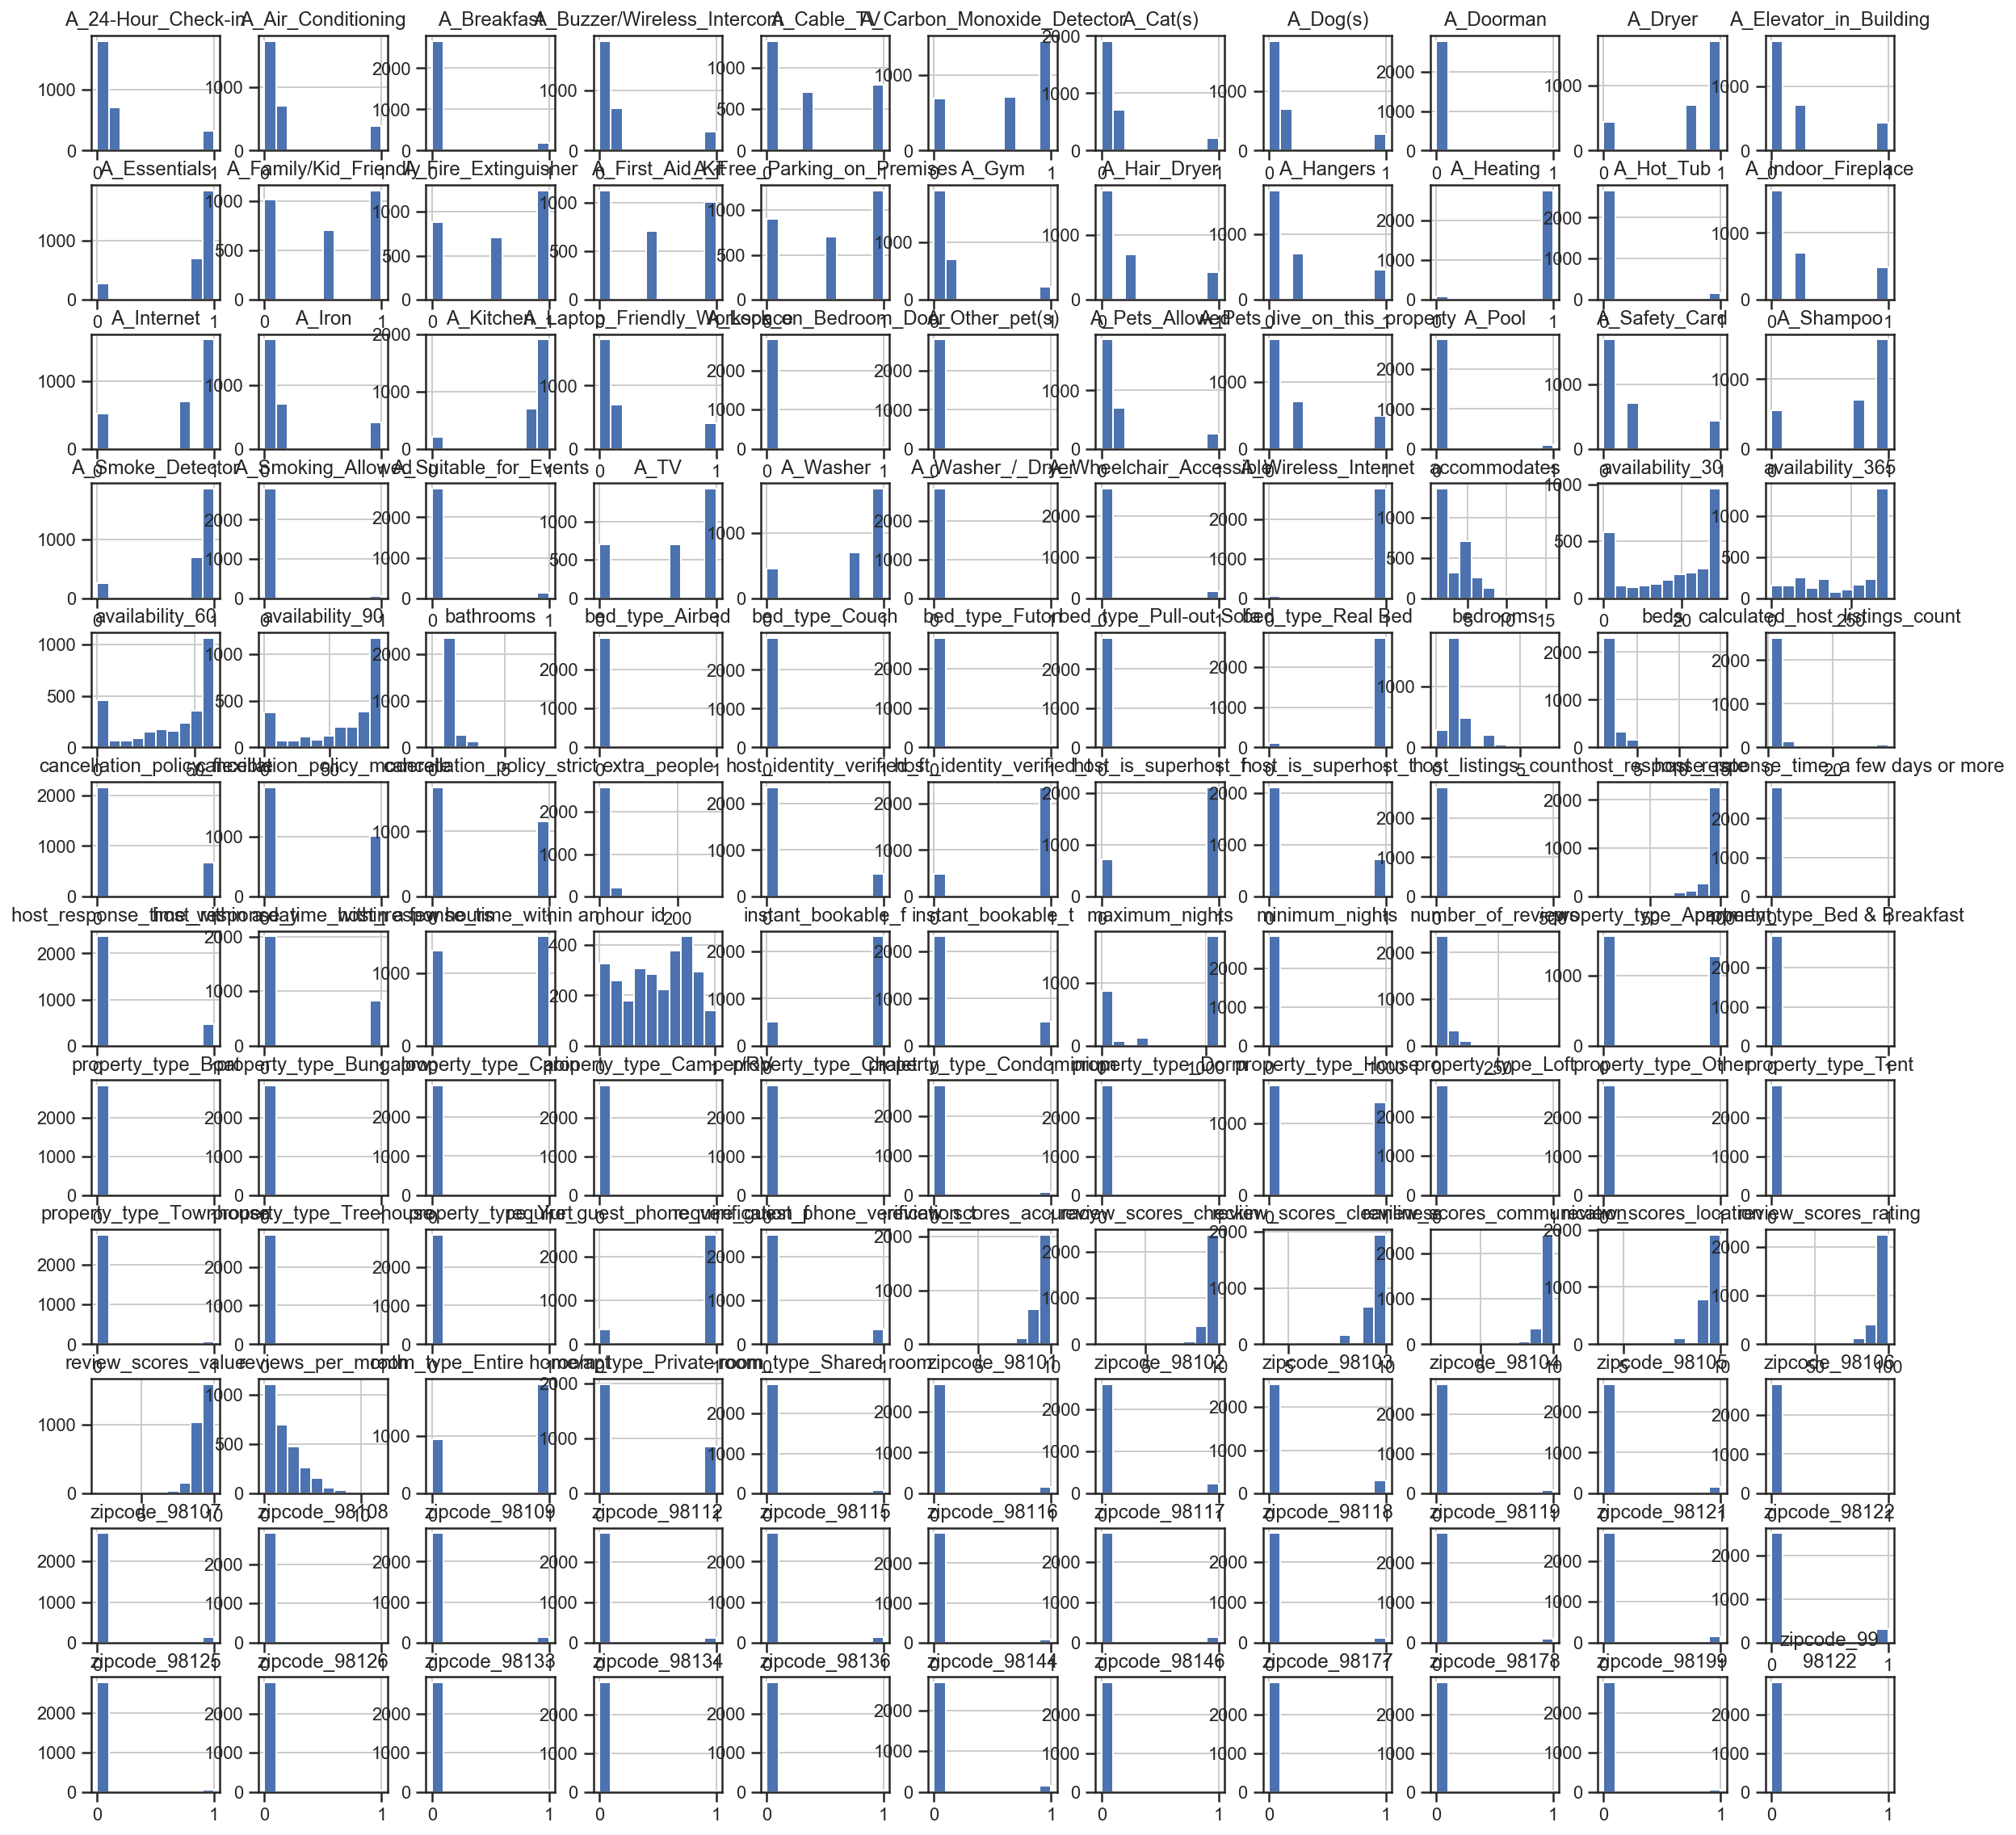

In [279]:
# distrubtion of each feature
dist_plot(df, fsize=(20,20))

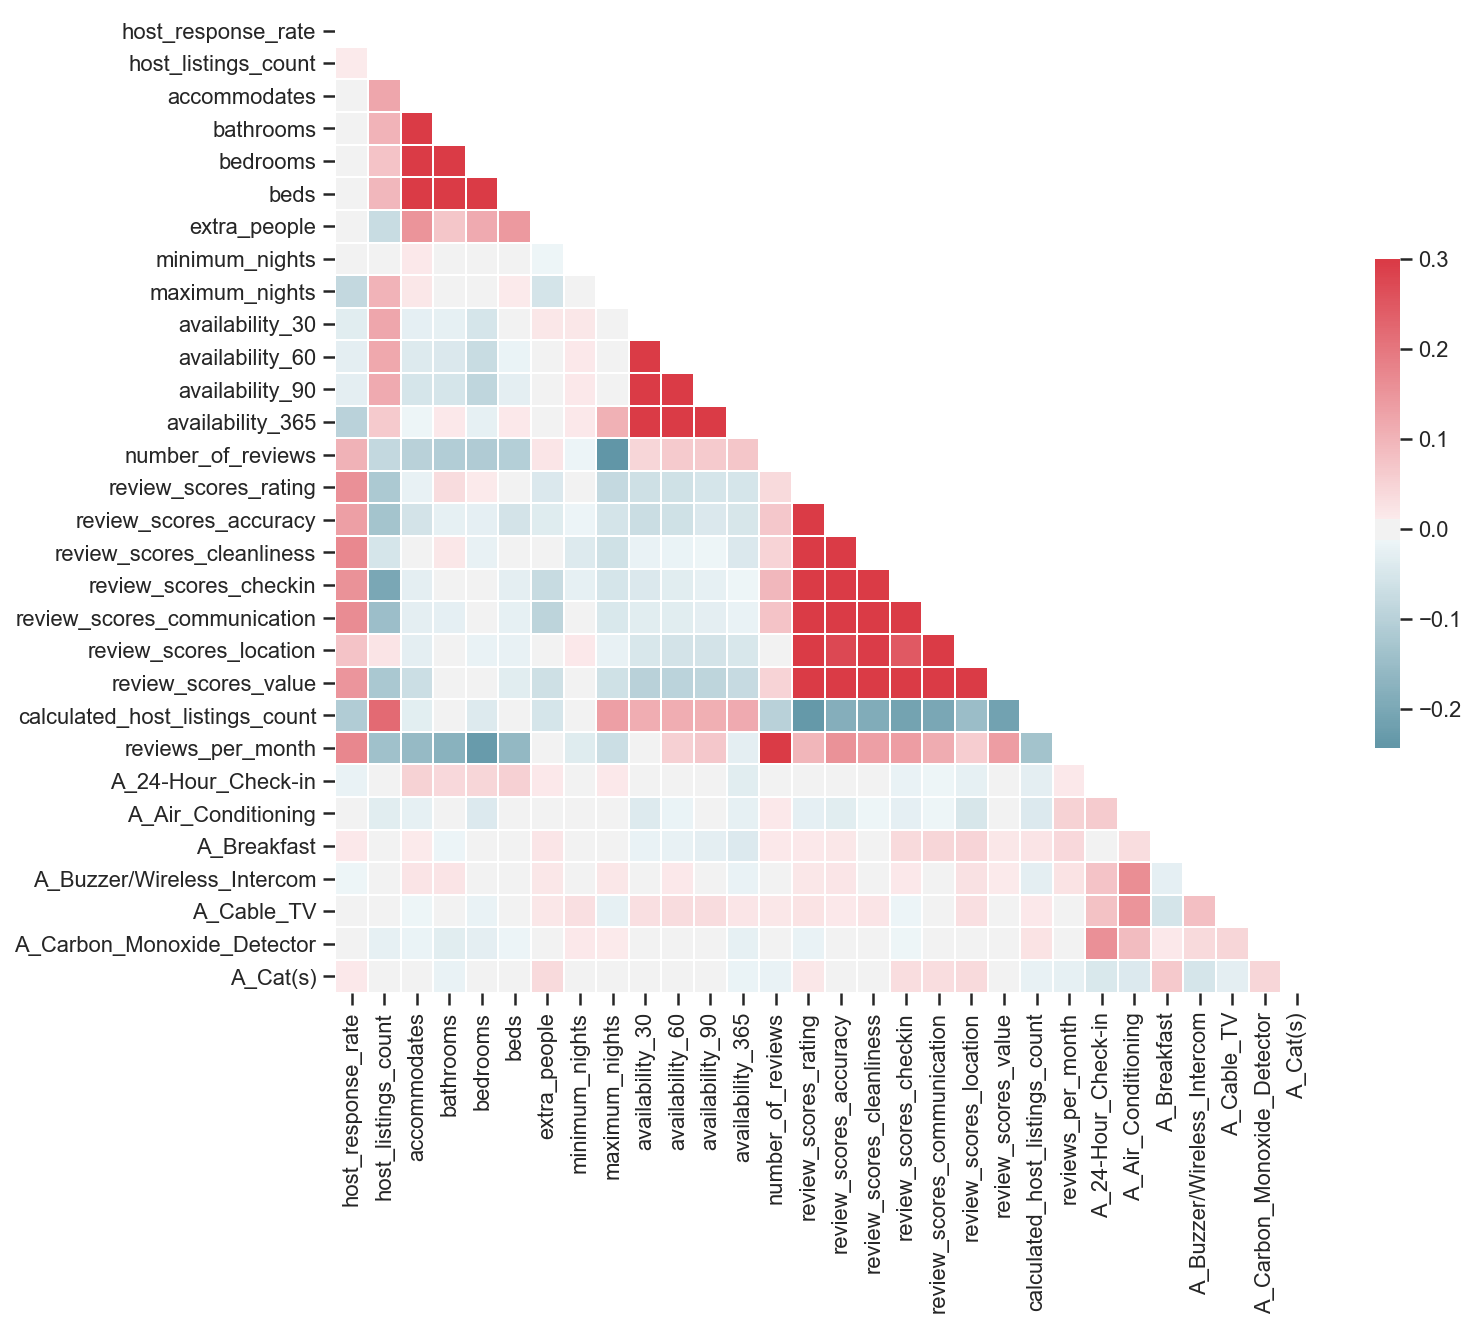

In [280]:
# correlations between different features. White color indicates 
# high similarity between the features

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = X.iloc[:,0:30].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [281]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature reviews_per_month (0.029954)
2. feature number_of_reviews (0.029185)
3. feature availability_365 (0.028036)
4. feature availability_90 (0.026337)
5. feature availability_60 (0.025957)
6. feature review_scores_rating (0.025797)
7. feature availability_30 (0.025549)
8. feature extra_people (0.022679)
9. feature accommodates (0.021986)
10. feature host_listings_count (0.020782)
11. feature minimum_nights (0.020265)
12. feature maximum_nights (0.020221)
13. feature calculated_host_listings_count (0.018775)
14. feature review_scores_value (0.017878)
15. feature beds (0.016819)
16. feature bedrooms (0.015826)
17. feature review_scores_cleanliness (0.015444)
18. feature review_scores_location (0.015413)
19. feature review_scores_accuracy (0.013920)
20. feature host_response_rate (0.013737)
21. feature bathrooms (0.013501)
22. feature A_Family/Kid_Friendly (0.012907)
23. feature A_Free_Parking_on_Premises (0.012731)
24. feature A_First_Aid_Kit (0.012412)
25. feature

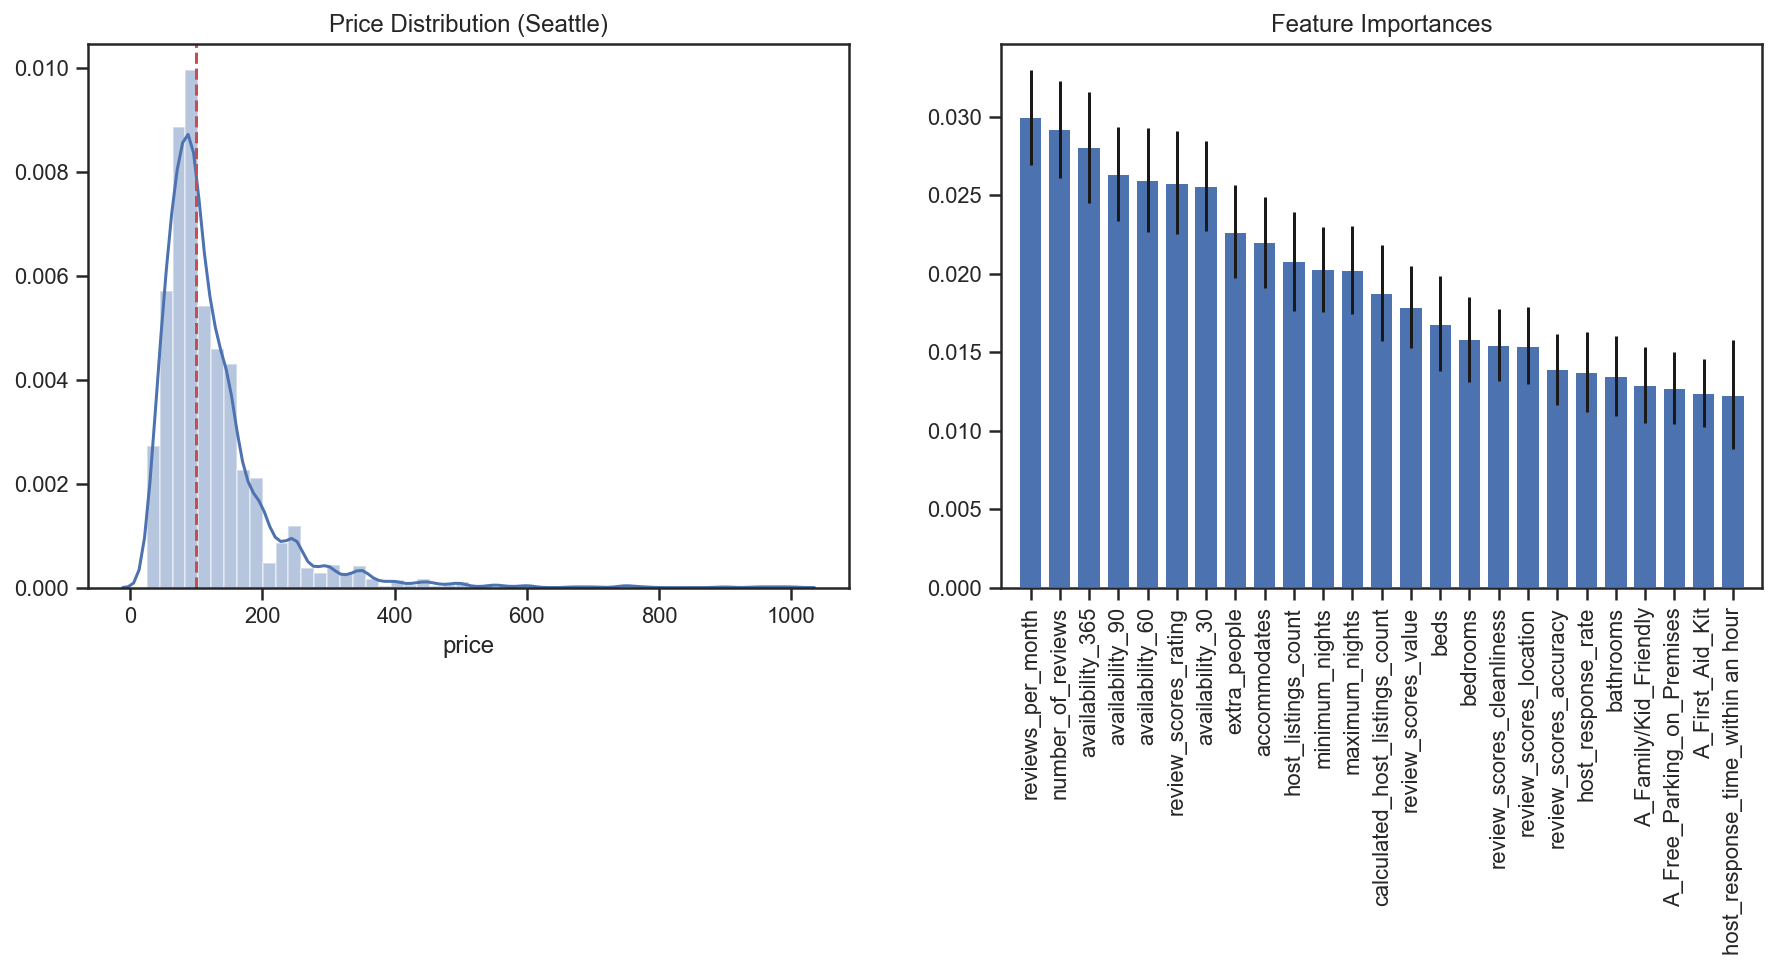

In [282]:
sns.set()
sns.set_style('ticks') 

f, axes = plt.subplots(1, 2, figsize=(15, 5))

# equivalent but more general
ax1=plt.subplot(1, 2, 1, frameon=True)
sns.distplot(y, ax=ax1)
ax1.axvline(np.median(y),color='r', linestyle='--')
ax1.title.set_text('Price Distribution (Seattle)')

# add a subplot with no frame
ax2=plt.subplot(122, frameon=True)
ax2.title.set_text('Feature Importances')
num_features = 25
indices1 = indices[:num_features]
ax2.bar(range(num_features), importances[indices1],
       color="b", yerr=std[indices1], align="center")

ax2.set_xlim(xmin=-1, xmax=num_features)
ax2.set_xticks(range(num_features))
ax2.set_xticklabels(X.columns[indices1], rotation=90)
plt.show()

## Modeling

In [196]:
# split data into test and training where we will train our model on train data
# and evaluate it on test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [199]:
# Now we build a linear regression model based on Keras to predict housing prices
model = Sequential()
model.add(Dense(1, kernel_initializer='normal', activation="linear", input_shape=(X_train.shape[1],)))

model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8), 
              metrics=[metrics.mse])

train_history = model.fit(X_train, y_train, epochs=90, batch_size=10, validation_split=0.2, verbose=1)

Train on 1584 samples, validate on 396 samples
Epoch 1/90
1584/1584 [==============================] - 0s 295us/step - loss: 47067.4784 - mean_squared_error: 47067.4784 - val_loss: 12683.3407 - val_mean_squared_error: 12683.3407
Epoch 2/90
1584/1584 [==============================] - 0s 79us/step - loss: 13620.0841 - mean_squared_error: 13620.0841 - val_loss: 10514.2290 - val_mean_squared_error: 10514.2290
Epoch 3/90
1584/1584 [==============================] - 0s 80us/step - loss: 11420.4378 - mean_squared_error: 11420.4378 - val_loss: 9109.4018 - val_mean_squared_error: 9109.4018
Epoch 4/90
1584/1584 [==============================] - 0s 87us/step - loss: 9952.3613 - mean_squared_error: 9952.3613 - val_loss: 8630.5487 - val_mean_squared_error: 8630.5487
Epoch 5/90
1584/1584 [==============================] - 0s 89us/step - loss: 8999.1984 - mean_squared_error: 8999.1984 - val_loss: 7757.2152 - val_mean_squared_error: 7757.2152
Epoch 6/90
1584/1584 [==============================] - 0

# Evaluation

In [200]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.53562574342448


In [201]:
# average housing price for our test data
np.mean(y_test_pred)

132.38467

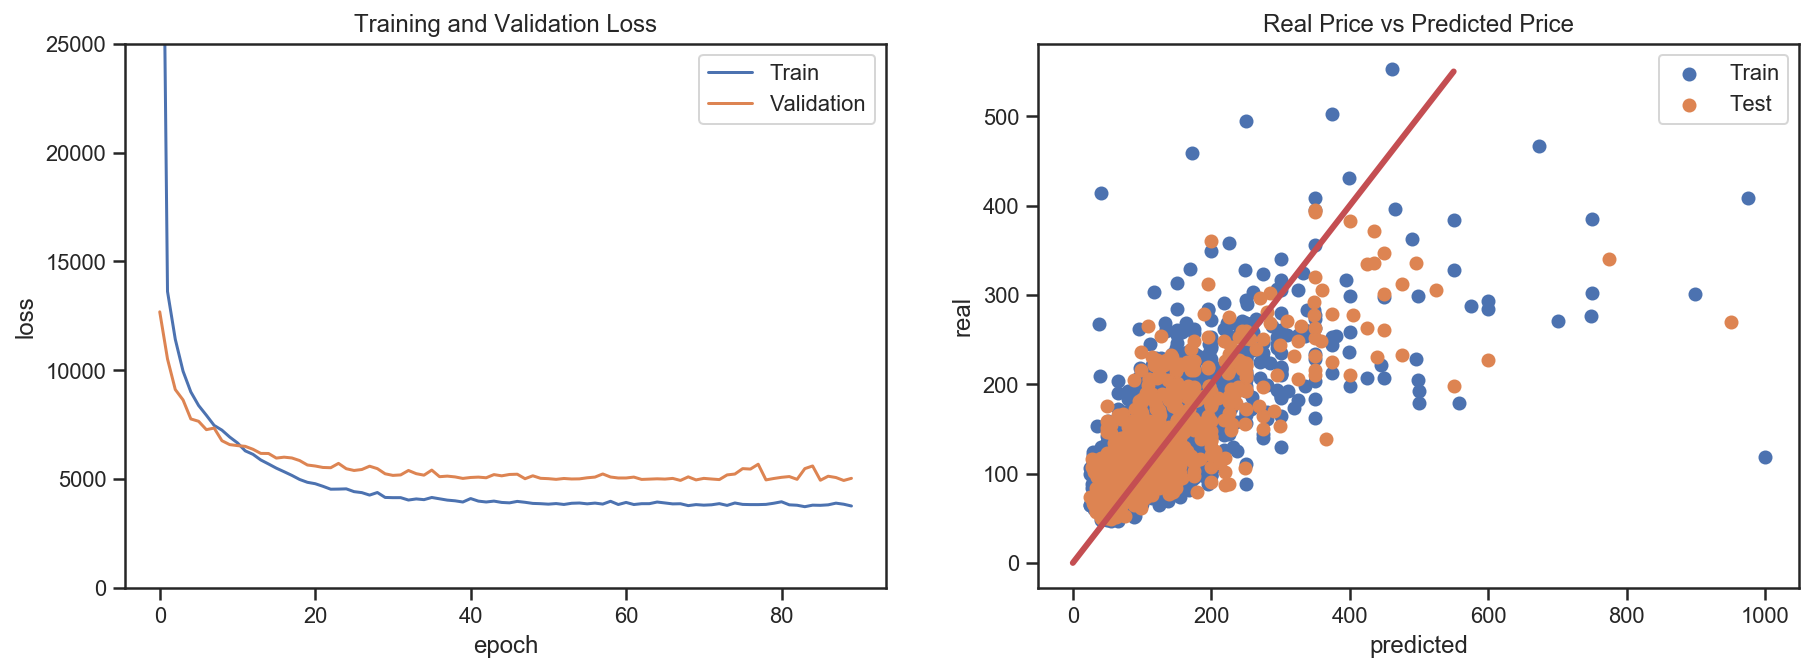

In [202]:
sns.set_style('ticks') 
f, axes = plt.subplots(1, 2, figsize=(15, 5))

# equivalent but more general
ax1=plt.subplot(1, 2, 1, frameon=True)
ax1.plot(train_history.history['mean_squared_error'])
ax1.plot(train_history.history['val_mean_squared_error'])
ax1.legend(['Train', 'Validation'])
ax1.set_ylim([0,25000])
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.title.set_text('Training and Validation Loss')

# add a subplot with no frame
ax2=plt.subplot(122, frameon=True)
ax2.scatter(y_train, y_train_pred)
ax2.scatter(y_test,y_test_pred)
ax2.set_xlabel('predicted')
ax2.set_ylabel('real')
ax2.legend(['Train', 'Test'])
ax2.title.set_text('Real Price vs Predicted Price')
ax2.plot([0, 550], [0, 550], c='r', linewidth=3)

# 2. Review Analyzing

## Business Understanding

We compare housing reviews between different cities and find out 
if Seattle area is a good place for housing. 
For this purpose, we analyze reviews of listings for each city

## Data Understanding

In [62]:
# loading hosting reviews in seattle houses
def read_reviews(city_name):
    """
    Description: This function can be used to read reviews for a given city
    
    Arguments:
        city_name: input city name
        
    Returns:
        reviews of the city
    """
    
    df_ = pd.read_csv('data/' + city_name + '/reviews.csv')
    return df_

# To evaluate reviews for cities, text reviews of hosts are 
# obtained from Airbnb for three different cities
seattle_reviews_df = read_reviews('seattle')
boston_reviews_df = read_reviews('boston')
beijing_reviews_df = read_reviews('beijing')

In [58]:
seattle_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [55]:
boston_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


beijing_reviews_df.head()

## Data Preparation

In [45]:
def sample_rows(df, n):
    """
    Description: Read dataframe and sample n rows from the dataframe
    
    Arguments:
        df: dataframe
         n: number of rows to sample
        
    Returns:
        dfx: sampled dataframe
    """
    
    # create random index
    rindex =  np.array(sample(range(len(df)), n))

    # get n random rows from df
    dfr = df.ix[rindex]
    
    return dfr

sample_size = min([beijing_reviews_df.shape[0], boston_reviews_df.shape[0], seattle_reviews_df.shape[0]])

# Retrieve only comments from each dataframe
seattle_reviews_df = seattle_reviews_df[['comments']]
boston_reviews_df = boston_reviews_df[['comments']]
beijing_reviews_df = beijing_reviews_df[['comments']]

# For fair comparison, randomly sample the same number of reviews for each dataset
seattle_reviews_df = sample_rows(seattle_reviews_df, sample_size)
boston_reviews_df = sample_rows(boston_reviews_df, sample_size)
beijing_reviews_df = sample_rows(beijing_reviews_df, sample_size)

# We don't need to normalize and preprocess text data since 
# TextBlob does it all for us, so we skip those steps

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Modeling

Each review is classified into positive or negative category based on its content. Pre-trained sentiment analysis model (TextBlob) was used for review classification. 

In [48]:
def sentiment_analyse(text):
    """
    Description: This function can be used to read a text and predict whether
    it is positive or negative

    Arguments:
        text: the input text (any)

    Returns:
        a value between -1 and 1 where -1 is negative and 1 is positive
    """
    try:
        return TextBlob(text).sentiment[0]
    except:
        return 0

seattle_reviews['sentiment'] = seattle_reviews['comments'].apply(sentiment_analyse)
boston_reviews['sentiment'] = boston_reviews['comments'].apply(sentiment_analyse)
beijing_reviews['sentiment'] = beijing_reviews['comments'].apply(sentiment_analyse)

## Evaluation

In [49]:
print('Example review:', beijing_reviews["comments"][0])
print('Sentiment score:', TextBlob(seattle_reviews["comments"][0]).sentiment[0])

example review: Sev was very helpful.  Sev showed us where to shop and the prices we could expect to pay.  Offered his assistance after handing us the room key.  Sev is a great guy to deal with when visiting Beijing.
sentiment score: 0.43333333333333335


In [50]:
print('Example review:', seattle_reviews["comments"][0])
print('Sentiment score:', TextBlob(seattle_reviews["comments"][0]).sentiment[0])

example review: Cute and cozy place. Perfect location to everything! 
sentiment score: 0.43333333333333335


Text(0.5, 0, 'review score')

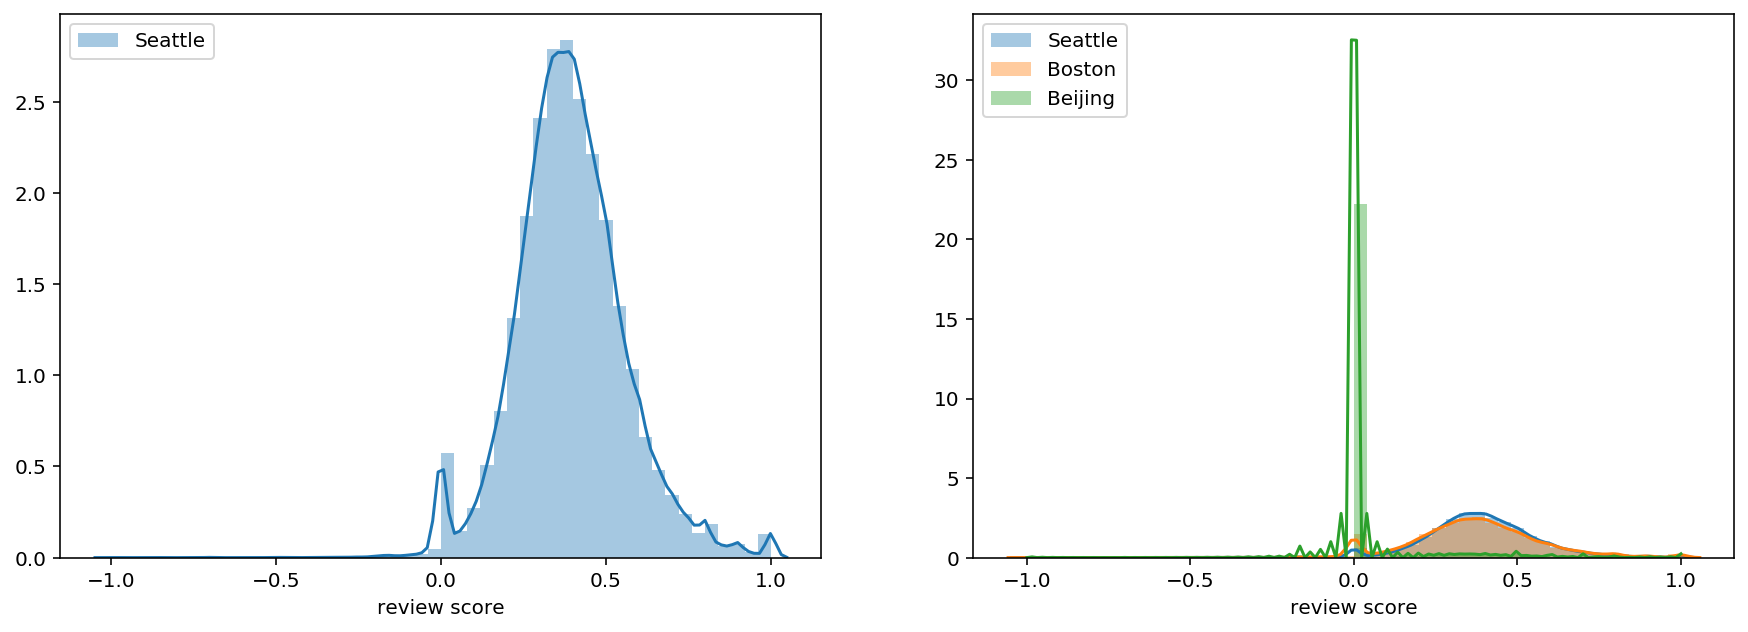

In [51]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(seattle_reviews['sentiment'], ax=axes[0])
axes[0].legend(title='', loc='upper left', labels=['Seattle'])
axes[0].set_xlabel("review score")

sns.distplot(seattle_reviews['sentiment'],  label="Seattle", ax=axes[1])
sns.distplot(boston_reviews['sentiment'],  label="Boston", ax=axes[1])
sns.distplot(beijing_reviews['sentiment'],  label="Beijing", ax=axes[1])
plt.legend(title='', loc='upper left', labels=['Seattle', 'Boston', 'Beijing'])
axes[1].set_xlabel("review score")

# 3. The Busiest Season

## Business Understanding

It is important that helps house renters to plan their holiday in advance and hosts to seasonally adjust their housing prices according to the market. For this purpose, we analyze house renting activities and find out what month is the busiest of the year and what is the price for each month.

## Data Understanding

In [69]:
# Read data
calendar = pd.read_csv('data/seattle/calendar.csv')
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Data Preparation

In [70]:
# Converting date string into year, month, day, weekday values
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar.date.dt.month
calendar['year'] = calendar.date.dt.year
calendar['day'] = calendar.date.dt.day
calendar['weekday'] = calendar.date.dt.dayofweek
calendar['available'] = np.where(calendar['available'] == 'f', 0, 1)

calendar=calendar[(calendar['date']>datetime.date(2016,1,1)) & (calendar['date']<datetime.date(2016,12,31))]  

calendar.head()

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  # Remove the CWD from sys.path while we load stuff.


,listing_id,date,available,price,month,year,day,weekday
0,241032,2016-01-04,1,85.0,1,2016,4,0
1,241032,2016-01-05,1,85.0,1,2016,5,1
2,241032,2016-01-06,0,NaN,1,2016,6,2
3,241032,2016-01-07,0,NaN,1,2016,7,3
4,241032,2016-01-08,0,NaN,1,2016,8,4


## Data Modeling

In [74]:
# visits that were denied
not_booked_visits = calendar[calendar['available'] == 1]
# visits that were booked
booked_visits = calendar[calendar['available'] == 0]

In [75]:
# monthly visits that were booked
price_per_month = booked_visits[['price', 'month']]
price_per_month = price_per_month.groupby('month').mean()

We show the number of renting requests that were denied due to the reason that guest houses were not available or booked by someone else at the time.

In [80]:
failed_visits = calendar[['month', 'available']]
failed_visits = failed_visits.groupby('month')['available'].sum()

In [226]:
# Group visits by month so that we can analize activities for each month
grouped_data = calendar.groupby(['date']).agg(['sum', 'count'])
grouped_data.loc[:, 'avg'] = grouped_data['available']['count'] - grouped_data['available']['sum']

dates = pd.to_datetime(list(grouped_data.index))
dates = matplotlib.dates.date2num(dates)

# Evaluation

Lastly, let’s look at monthly visits. The first graph shows the number of requests per month. It only shows the number of renting requests that were denied due to the reason that guest houses were not available or booked by someone else at the time. The second graph shows the average housing price for each month. In the summer, the number of visits is expected to increase as most people take their holiday and spend time in another city or country. Especially, June is the busiest month of the year. As the number of visits increases, the housing price gets higher. For example, from March to June, the housing price almost doubled. However, if you look at the visits on the first graph, the number of requests unexpectedly spiked in January.

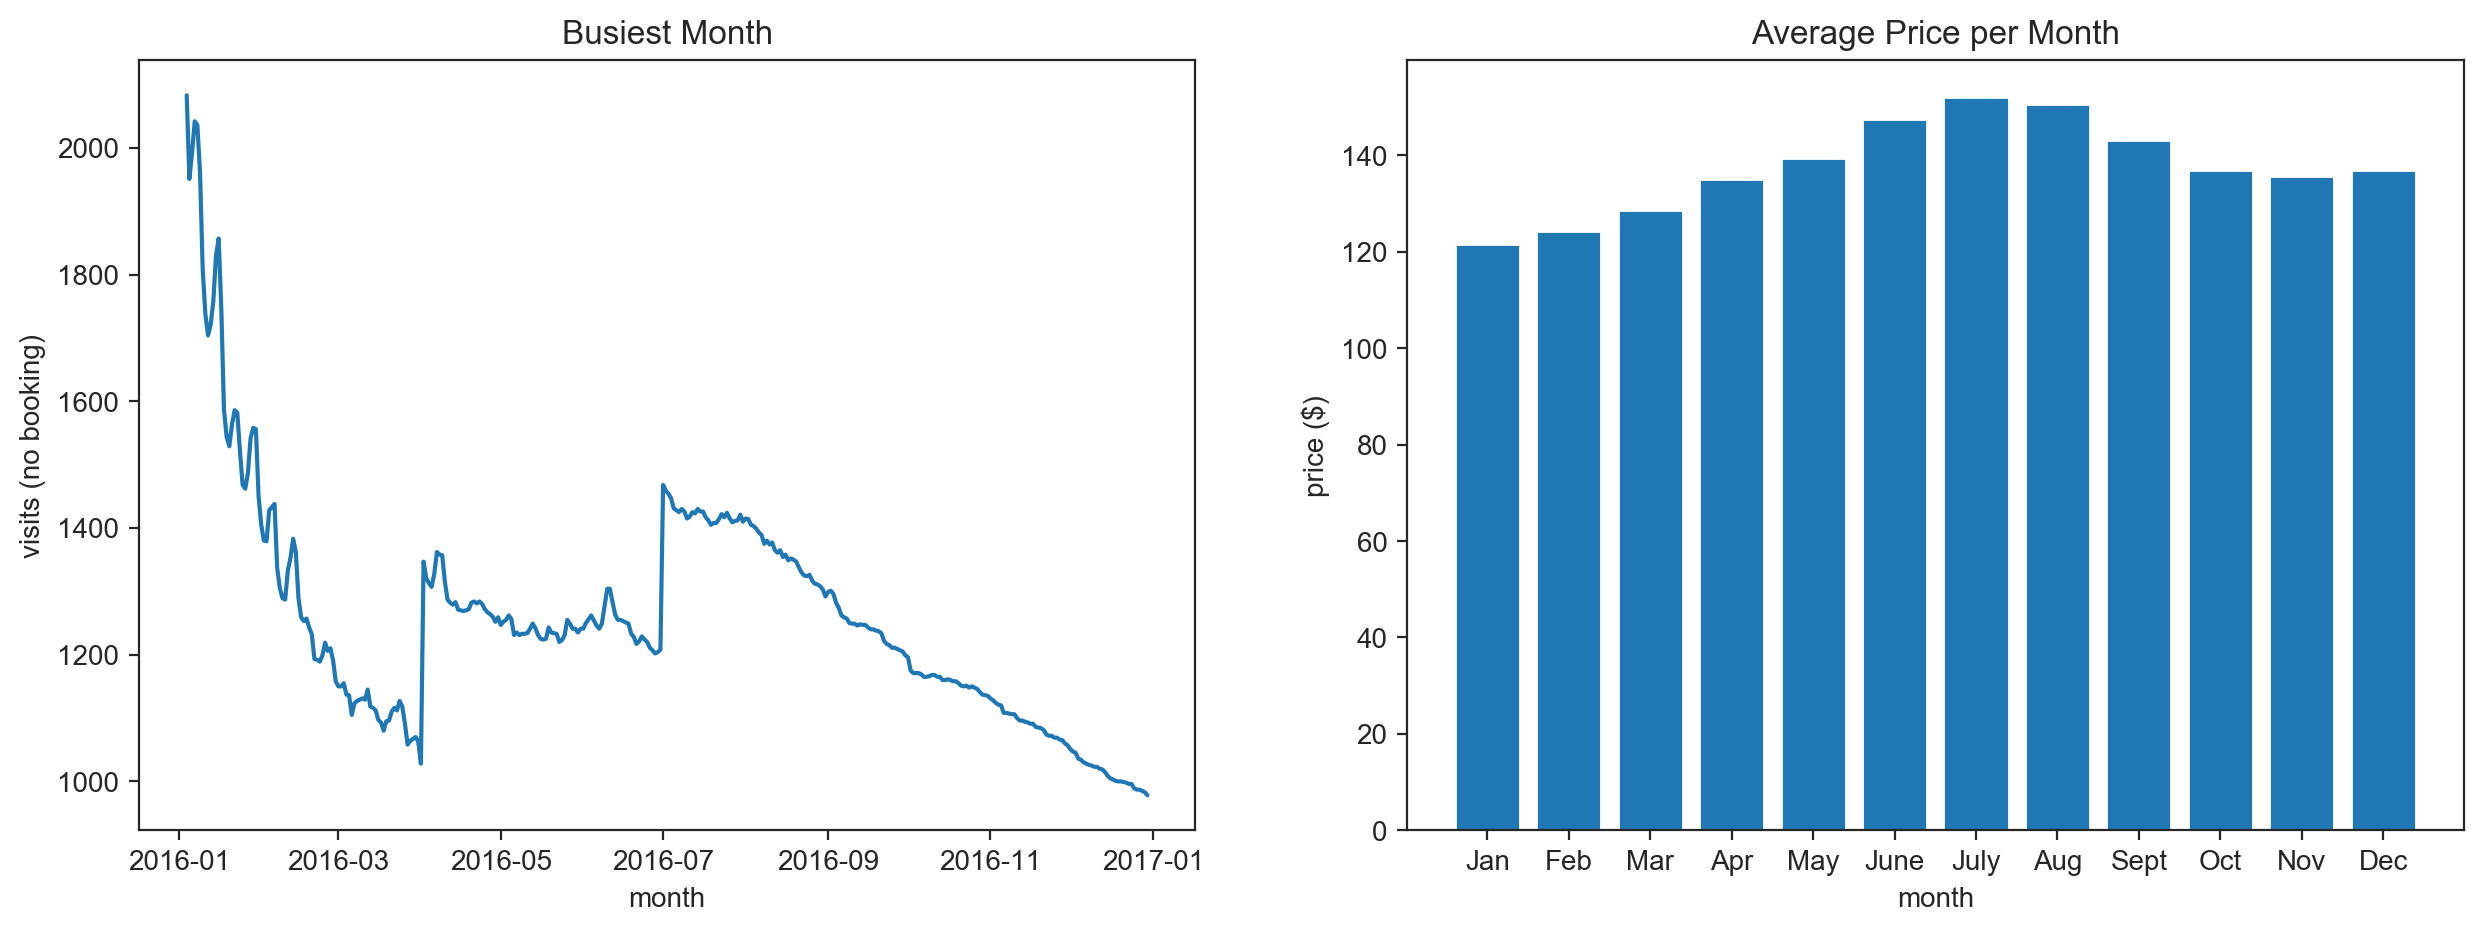

In [231]:
sns.set_style('ticks') 

months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

f, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1=plt.subplot(1, 2, 1, frameon=True)
ax1.plot_date(dates, grouped_data.avg.tolist(), '-')
ax1.set_xlabel('month')
ax1.set_ylabel('visits (no booking)')
ax1.title.set_text('Busiest Month')

ax2=plt.subplot(122, frameon=True)
ax2.bar(months, price_per_month['price'])
ax2.set_xlabel('month')
ax2.set_ylabel('price ($)')
ax2.title.set_text('Average Price per Month')